# Marine Heat Wave analysis
The purpose of this notebook is to take in SST data, along with previously computed climatology and threshold, process these and output any MHW events that occur in the data

First, we import the data and required modules. 

In [1]:
import xarray as xr
import now
import numpy as np
from datetime import date
from matplotlib import pyplot as plt
from dask.distributed import LocalCluster, Client
import dask as da
from scipy.ndimage import label, generate_binary_structure
import time
from cartopy import config
import cartopy.crs as ccrs
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cluster = LocalCluster(processes=False, local_dir= "/g/data1a/e14/rm6294/dask-workers")
client = Client(cluster)
client

Client Scheduler: inproc://10.0.64.27/24483/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 8 Memory: 33.67 GB


In [5]:
# Opens Climatology and MHW SST threshold files, that have been created before.
# Note: p stands for past, f for future
localDir = "/g/data1a/e14/rm6294/NOWMHW/"
pThresh = xr.open_dataarray(localDir + 'pastThreshRep.nc')
pClim = xr.open_dataarray(localDir + 'pastClimRep.nc')
fThresh = xr.open_dataarray(localDir + 'futureThreshRep.nc')
fClim = xr.open_dataarray(localDir + 'futureClimRep.nc')

In [4]:
# Opens NOW SST data, from which we need the SST.
cfg = 'present_vs_future.ini'
sst = now.io.open_nemo_griddata_from_zarr(cfg, grid='T')['tos'] #tos means sst
# SST contains both future and past run. We now split that up.
sstPast = sst.sel(simulation = 'Present')
sstFut = sst.sel(simulation = 'Future')

In [6]:
# NOW data is daily, and runs from 1990/01/01T12:00:00 to 2008/12/31T12:00:00. We use this to create our t vector.
#Two lines below taken from example_synthetic file in MHW github
t = np.arange(date(1990,1,1).toordinal(),date(2008,12,31).toordinal()+1)
dates = [date.fromordinal(tt.astype(int)) for tt in t]

## Looking for MHW
The method we will be using to identify MHW is to:
* Create a mask on top of the data, which has a binary True/False representing whether the sst at the location is above the corressponding threshold. 
* Using the mask, try and find consecutive days where the threshold is crossed, as these represent the MHW.

### Creating a Mask
We are looking for SST to cross the threshold. We will do this by:
* Subtracting the background climatology from both the threshold and sst, giving us theshold anomaly (thresha) and SST anomaly (ssta).
* Dividing ssta by thresha.
* Saving the severity data, so we can simply call it for use in the animation section.
This process will not only give us a matrix of threshold crosses (as ssta > thresha at this points, ssta/thresa > 1), but also tell us about the severity of the MHW, as temperatures 2 thresholds away from the background will be represented with a two in the matrix and so on.

In [18]:
%%time
# Finding thresha and ssta
thresha = pThresh.chunk({'x':50, 'y':50, 'time_counter':365}) - pClim.chunk({'x':50, 'y':50, 'time_counter':365})
ssta = sstPast.chunk({'x':50, 'y':50, 'time_counter':365}) - pClim.chunk({'x':50, 'y':50, 'time_counter':365})

CPU times: user 2.73 s, sys: 668 ms, total: 3.4 s
Wall time: 3.15 s


In [19]:
%%time
mhws = xr.where(ssta > thresha, ssta/thresha, 0)
mhws['nav_lon'] = mhws['nav_lon'] % 360 

CPU times: user 3.04 s, sys: 682 ms, total: 3.72 s
Wall time: 3.29 s


In [20]:
mhws.to_netcdf("/g/data1a/e14/rm6294/NOWMHW/severityMHWNOW_pastRun.nc")

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


In [9]:
plt.rcParams["figure.figsize"] = [16,9]

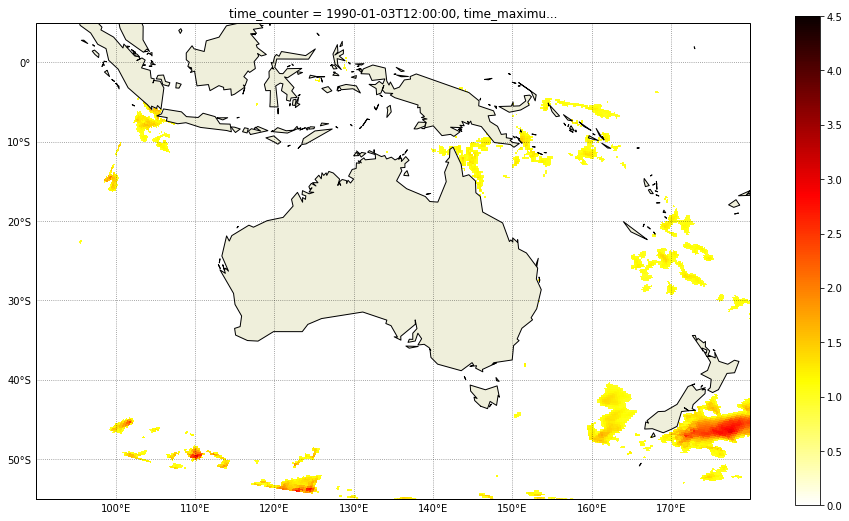

In [10]:
ax = plt.subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
now.plot.add_map(lon_min = 90, lon_max = 180, lat_min = -55,ax = ax, lat_max = 5)
sev_Past.isel(time_counter = 2).plot(x='nav_lon', y='nav_lat', cmap = 'hot_r',vmin = 0, vmax = 4.5, ax = ax);
#plt.savefig("/g/data1a/e14/rm6294/NOWMHW/MHWPlots/" + 'mhwPlot_{:0>3d}.png'.format(i),bbox_inches='tight')

## Creating an animation
This section will create a video showing severity of MHWs in the NOW data.

In [3]:
# First, importing all the data
localDir = "/g/data1a/e14/rm6294/NOWMHW/"
sev_Past = xr.open_dataarray(localDir + "severityMHWNOW_pastRun.nc").load()
sev_Fut = xr.open_dataarray(localDir + "severityMHWNOW_futureRun.nc")

In [4]:
%%time
plt.rcParams["figure.figsize"] = [16,9]
ax = plt.subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
# create a directory for plots. Currently plotting the past severity
plot_dir = "/g/data1a/e14/rm6294/NOWMHW/MHWPlots/"
lenT = 6940 # known previously
#i = 0
for i in range(5920, lenT  + 1): 
    now.plot.add_map(lon_min = 90, lon_max = 180, lat_min = -55,ax = ax, lat_max = 4.5)
    sev_Past.isel(time_counter = i).plot(x='nav_lon', y='nav_lat', cmap = 'hot_r',vmin = 0, vmax = 4.5, ax = ax);

    plt.savefig(plot_dir + 'mhwPlot_{:0>4d}.png'.format(i), bbox_inches='tight')
    plt.close('all')
    
    if i%100 == 0: 
        print('Saved figure', i)



Saved figure 6000
Saved figure 6100
Saved figure 6200
Saved figure 6300
Saved figure 6400
Saved figure 6500
Saved figure 6600
Saved figure 6700
Saved figure 6800
Saved figure 6900
CPU times: user 1h 6min 53s, sys: 2min 31s, total: 1h 9min 24s
Wall time: 45min 3s


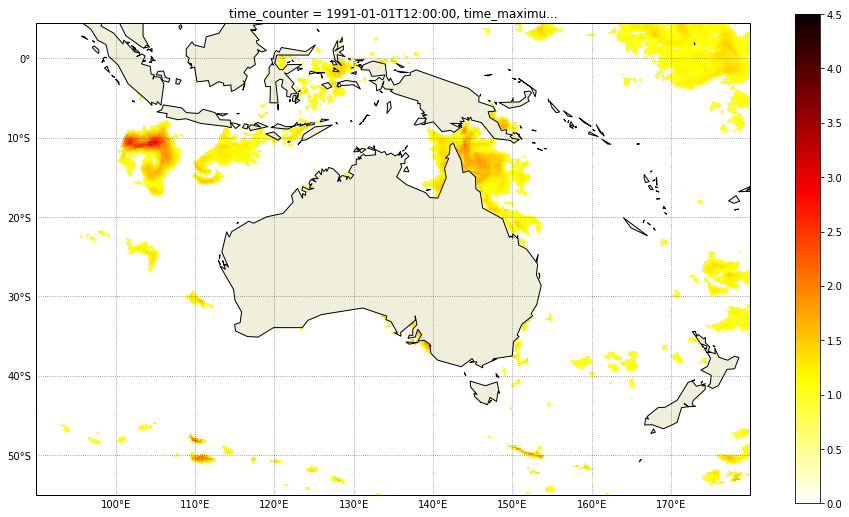

In [24]:
ax = plt.subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
now.plot.add_map(lon_min = 90, lon_max = 180, lat_min = -55,ax = ax, lat_max = 4.5);
sev_Past.isel(time_counter = 365).plot(x='nav_lon', y='nav_lat', cmap = 'hot_r',vmin = 0, vmax = 4.5, ax = ax);

# Trials

#### First, we will try with a subset of the entire dataset.
This subset will focus on the past data.

In [306]:
# Creating subset:
# key: p = past, f = fast, c = clim, t = threshold 
pcSub = pClim.isel(x = slice(220,320),y = slice(50,150))
ptSub = pThresh.isel(x = slice(220,320),y = slice(50,150))
sstSub = sstPast.isel(x = slice(220,320),y = slice(50,150))

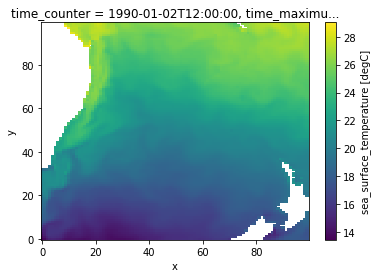

In [309]:
# Showing that we have taken a subset of the spacial dimension
sstSub.isel(time_counter = 1).plot();

In [15]:
pClim

<xarray.DataArray 'Mean Climatology for past NOW Run' (time_counter: 6940, y: 289, x: 431)>
[864439460 values with dtype=float32]
Coordinates:
    nav_lat          (y, x) float32 ...
    nav_lon          (y, x) float32 ...
    simulation       |S7 ...
  * time_counter     (time_counter) datetime64[ns] 1990-01-01T12:00:00 ... 2008-12-31T12:00:00
    time_maximum_1d  (time_counter) datetime64[ns] ...
    time_minimum_1d  (time_counter) datetime64[ns] ...
Dimensions without coordinates: y, x

In [310]:
%%time
# Finding thresha and ssta
thresha = ptSub.chunk({'x':10, 'y':10, 'time_counter':365}) - pcSub.chunk({'x':10, 'y':10, 'time_counter':365})
ssta = sstSub.chunk({'x':10, 'y':10, 'time_counter':365}) - pcSub.chunk({'x':10, 'y':10, 'time_counter':365})

CPU times: user 4.87 s, sys: 668 ms, total: 5.53 s
Wall time: 5.03 s


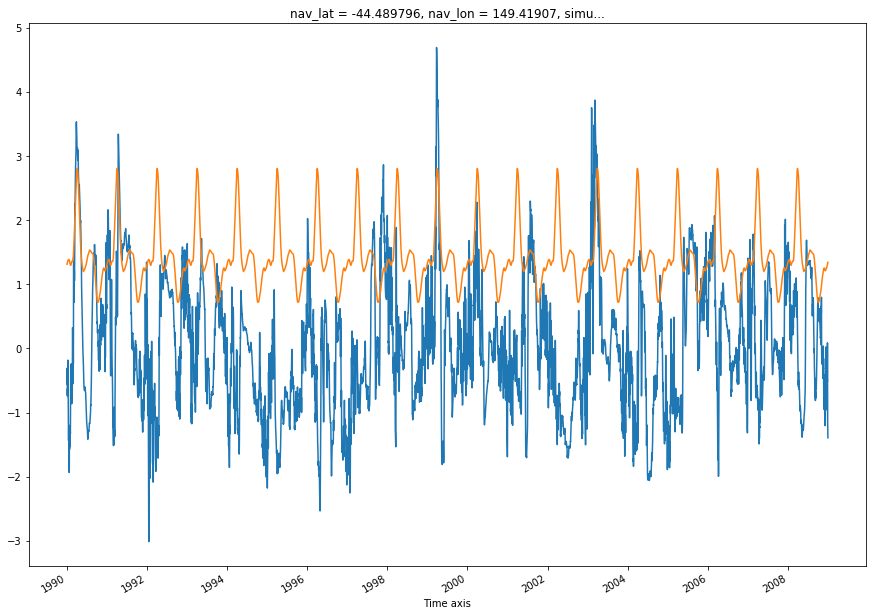

In [311]:
ssta.isel(x=1,y=2).plot(size = 10)
thresha.isel(x=1,y=2).plot();

In [394]:
%%time
#mhws = da.array.apply_along_axis(np.where, ssta.get_axis_num('time_counter'), ssta > thresha, ssta / thresha, 0)
#dif = ssta - thresha
mhws = xr.where(ssta > thresha, ssta/thresha, 0)

CPU times: user 4.74 s, sys: 765 ms, total: 5.51 s
Wall time: 4.88 s


This mhws array represents all the values for which the threshold is exceeded. MHWs have the additional stipulation that they must last for 5 or more days. The next part tries to follow what Oliver did to combat this problem

In [353]:
# Here we create the array structure that the label function will use
s = generate_binary_structure(2,2)
struc = np.array([s,s,s])
struc[1][1][1] = 0

In [431]:
struc

array([[[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True, False,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]])

In [314]:
%%time
# This function finds strings of consecutive nonzero numbers. 
labeled_array, num_features = label(mhws,struc)

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


In [383]:
num_features

6086

In [315]:
%%time
i = 0
for ev in range(1,num_features+1):
    event_duration = (labeled_array == ev).sum()
    if event_duration < 5:
        i += 1
        #print("Event " + str(ev) + " is a " + str(event_duration) + " day event ")
        labeled_array[np.where(labeled_array == ev)] = [0]
        
num_features -= i

In [316]:
marHw = xr.DataArray(labeled_array, coords = mhws.coords, dims = mhws.dims)

In [344]:
pcSub.isel(x=2, y = 60, time_counter= 1)

<xarray.DataArray 'Mean Climatology for past NOW Run' ()>
array(nan, dtype=float32)
Coordinates:
    nav_lat          float32 ...
    nav_lon          float32 ...
    simulation       |S7 ...
    time_counter     datetime64[ns] 1990-01-02T12:00:00
    time_maximum_1d  datetime64[ns] ...
    time_minimum_1d  datetime64[ns] ...

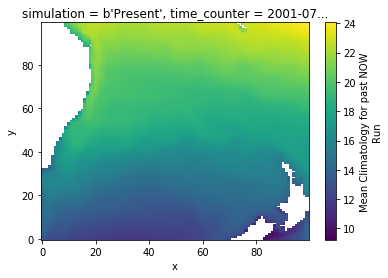

In [336]:
pcSub.isel(time_counter = 4225).plot();

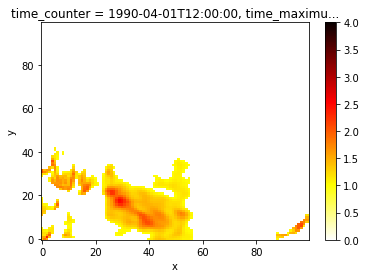

In [390]:
mhws.isel(time_counter = 90).plot(cmap = 'hot_r', vmin = 0, vmax = 4);

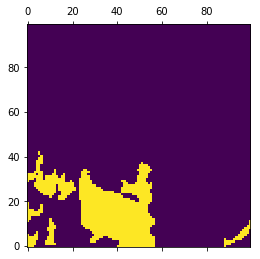

In [389]:
matshow(labeled_array[90], origin = 'lower')#.isel(time_counter = 1).plot(cmap = 'hot_r', vmin = 0, vmax = 4);